In [2]:
from connectPyspark import *
import pyspark.sql.functions as f
import shutil
import pyspark.sql.functions as F
def print_source(f):
    import inspect
    print(inspect.getsource(f))

:: loading settings :: url = jar:file:/home/pc/TestJupyter/opt/spark-3.3.0/spark-3.3.0-bin-hadoop3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pc/.ivy2/cache
The jars for the packages stored in: /home/pc/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-333c8517-c84b-4982-81f7-9699911af76c;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.3.0 in central
	found org.tukaani#xz;1.8 in central
	found org.spark-project.spark#unused;1.0.0 in central
:: resolution report :: resolve 123ms :: artifacts dl 4ms
	:: modules in use:
	org.apache.spark#spark-avro_2.12;3.3.0 from central in [default]
	org.spark-project.spark#unused;1.0.0 from central in [default]
	org.tukaani#xz;1.8 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |

22/10/11 08:15:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/11 08:15:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/11 08:15:49 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/11 08:15:49 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/11 08:15:49 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [2]:
%load_ext autoreload
%autoreload 2
import connectPyspark as cp
from connectPyspark import *
import utilities as u
import shutil

[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using state  server backend.


### STEP 9 : Filter out sentence relavent to keywords

In [3]:
engKey = "seller|recommend|nice"
chiKey = "好|赞|不错|快|喜欢|谢|值|包装|卖家"
bmKey = "berbaloi|barang|cantik|murah"

s = read_avro("output/5_BI_BC_BM.avro")
s = s.filter( s.text.rlike(f"{engKey}|{chiKey}|{bmKey}"))
s = s.coalesce(74)

In [4]:
s.show(1000, False)

# 🆂🅰🅼🅿🅻🅴
### CLICK HERE TO SHOW SAMPLE WITH KEYWORDS

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|text                                                                                                                                                                                                                                                                                                        |lang          |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|beli dah banyak kali dengan seller ni        

In [53]:
s.count()

5634808

### STEP 10 : Sentence statistics on word count

In [54]:
import utilities as u
from pyspark.sql.functions import size

s = s.withColumn("token", u.tokenize_chineseDF(s.text))
s = s.withColumn("length", size(s.token))

In [57]:
write_avro(s, "output/10_sentence_statistics.avro")

[nltk_data] Downloading package stopwords to /home/pc/nltk_data...(0 + 18) / 21]
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data

### Step 11 : select those sentence out that is not outliers

In [3]:
s = read_avro("output/10_sentence_statistics.avro")
s = s.coalesce(74)

In [6]:
s.show(100, False)

# 🆂🅰🅼🅿🅻🅴
### CLICK HERE TO SHOW SENTENCE STATISTICS

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|text                                                                                                                                                                                                                                           |lang          |token                                                                                                                                                                                                  

In [6]:
bc = s.filter( (s.lang == "Language.CHINESE") & (s.length > 3))
bm = s.filter( (s.lang == "Language.MALAY") &  (s.length > 3))
bi = s.filter( (s.lang == "Language.ENGLISH") &  (s.length > 3))
bc = bc.coalesce(74)
bm = bm.coalesce(74)
bi = bi.coalesce(74)

In [60]:
bcC = bc.select(bc.length).count()
bmC = bm.select(bm.length).count()
biC = bi.select(bi.length).count()

In [62]:
print(f"chinese = {bcC} \n malay={bmC} \n english={biC}")

chinese = 131087 
 malay=2365843 
 english=1315187


In [63]:
bcC = bc.select(bc.length)
bmC = bm.select(bm.length)
biC = bi.select(bi.length)

<AxesSubplot:>

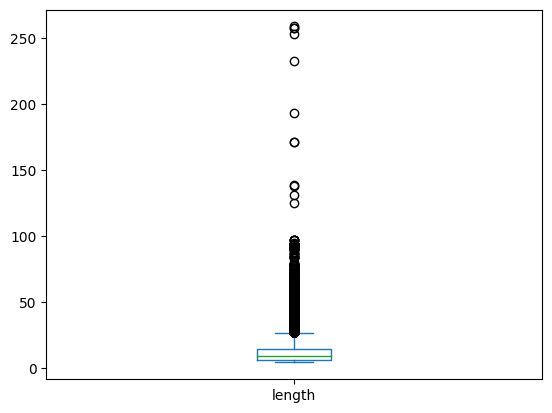

In [64]:
bmC.toPandas().plot.box()

<AxesSubplot:>

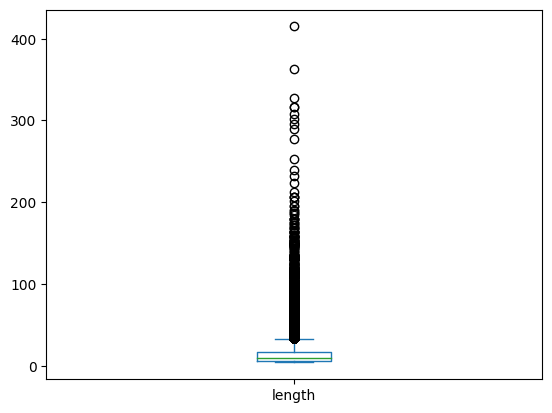

In [65]:
bcC.toPandas().plot.box()

<AxesSubplot:>

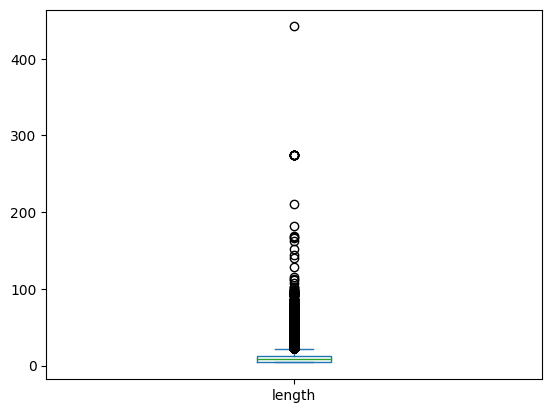

In [66]:
biC.toPandas().plot.box()

### STEP 12 : REMOVE THE OUTLIERS
- remove those outliers, with flags == 1

In [4]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [7]:
obc = find_outliers(bc)
obm = find_outliers(bm)
obi = find_outliers(bi)

In [109]:
bcC = nobc.select(nobc.length)
bmC = nobm.select(nobm.length)
biC = nobi.select(nobi.length)

<AxesSubplot:>

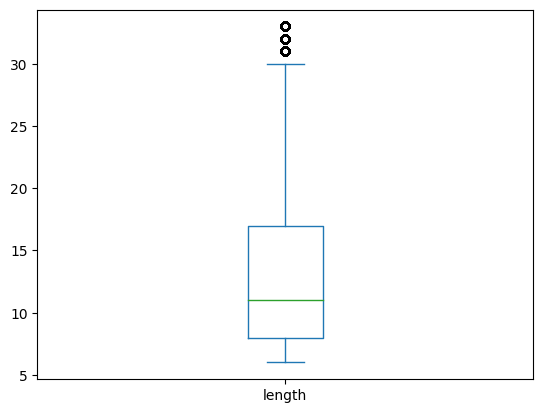

In [110]:
bcC.toPandas().plot.box()

<AxesSubplot:>

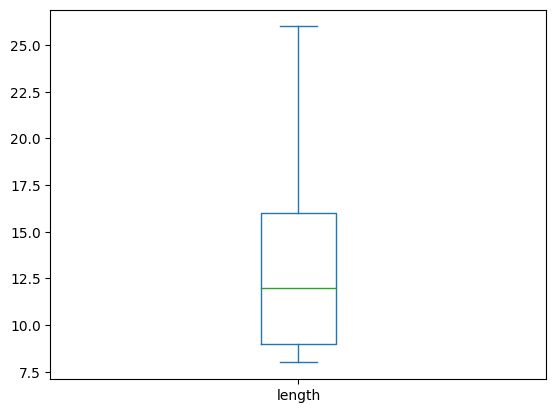

In [111]:
bmC.toPandas().plot.box()

<AxesSubplot:>

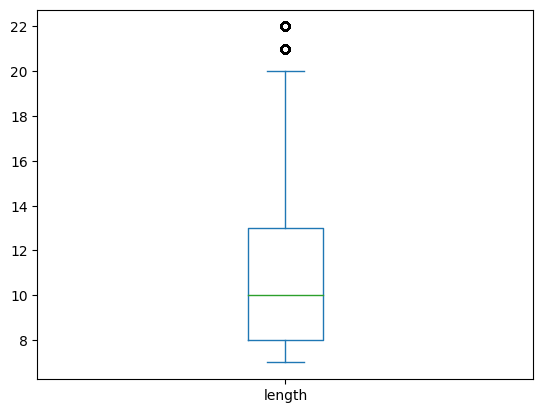

In [112]:
biC.toPandas().plot.box()

In [18]:
obi.filter(obi.total_outliers < 1).show(1000, False)

+----------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+------+--------------+
|text                                                                                                                                    |lang            |token                                                                                                                                                        |length|total_outliers|
+----------------------------------------------------------------------------------------------------------------------------------------+----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+------+--------

In [106]:
nobc = obc.filter((obc.total_outliers != 1) & (obc.length > 5)).filter(~F.col("text").contains("good good"))
nobm = obm.filter((obm.total_outliers != 1)  & (obm.length > 7)).filter(~F.col("text").contains("good good")).sample(True,0.52,123)
nobi = obi.filter((obi.total_outliers != 1)  & (obi.length > 6)).filter(~F.col("text").contains("good good")).sample(True,0.90,123)

In [114]:
from pyspark.sql.functions import avg, col
bmAvg = nobm.select(avg(nobm.length).alias("avg")).select(col("avg")).toPandas().iloc[0].item()
biAvg = nobi.select(avg(nobi.length).alias("avg")).select(col("avg")).toPandas().iloc[0].item()
bcAvg = nobc.select(avg(nobc.length).alias("avg")).select(col("avg")).toPandas().iloc[0].item()

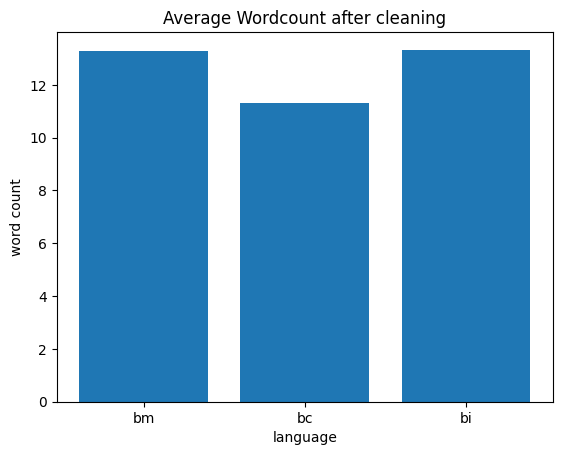

In [115]:
import matplotlib.pyplot as plt
plt.bar(["bm","bc","bi"],[bmAvg, biAvg, bcAvg])
plt.title('Average Wordcount after cleaning')
plt.xlabel('language')
plt.ylabel('word count')
plt.show()

In [107]:
data = \
f"""
nobc = {nobc.count()}
nobm = {nobm.count()}
nobi = {nobi.count()}
"""

In [108]:
print(data)


nobc = 96961
nobm = 651316
nobi = 655400



### STEP 13 :MERGE & SAVE

In [116]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [119]:
df = unionAll(nobc, nobm, nobi).drop("token").drop("length").drop("total_outliers")

In [122]:
write_avro(df, "output/11_TOPICS_SENTENCES")

In [124]:
df.write.csv("output/11_TOPICS_SENTENCES_DATA")

----------------------------------------                                        
Exception occurred during processing of request from ('127.0.0.1', 35384)
Traceback (most recent call last):
  File "/opt/python39/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/python39/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/python39/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/python39/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/pc/TestJupyter/opt/spark-3.3.0/spark-3.3.0-bin-hadoop3/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/pc/TestJupyter/opt/spark-3.3.0/spark-3.3.0-bin-hadoop3/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/home/pc/Tes